## Aprendizaje no supervisado - reducción de dimensión

- Se presentan los conceptos y simulaciones básicas relacionadas con técnicas clásicas lineales y no lineales de reducción de dimensión.

## Análisis de componentes de principales - Principal Component Analysis (PCA)

**Ejemplo:** Construyamos un conjunto de datos 3D del famoso dato sintético rollo Suizo - Swiss Roll.

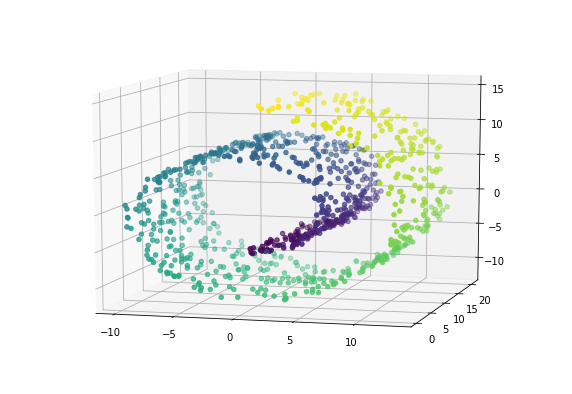

In [19]:
from sklearn.datasets import make_swiss_roll
import numpy as np
import matplotlib.pyplot as plt

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
#t contiene el orden estructural de los datos
#crear scatter en 3D
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(X[:,0], X[:,1], X[:,2],c=t)
ax.view_init(elev=10, azim=-75)
plt.show()

**NOTA:** PCA supone que el conjunto de datos se centra en el origen. Como veremos, las clases de PCA de Scikit-Learn se encargan de centrar los datos por usted. Sin embargo, si implementa PCA usted mismo, o si usa otras bibliotecas, **no olvide centrar los datos primero**, incluso considere aplicar normalización zscore.

### Usando PCA de scikit-learn

-La clase PCA de Scikit-Learn implementa PCA usando la descomposición espectral (EIG y SVD). 

-El siguiente código aplica PCA para reducir la dimensionalidad del conjunto de datos a dos dimensiones (tenga en cuenta que automáticamente se encarga de centrar los datos):

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
Y2D = pca.fit_transform(X)

- El hiperparámetro `n_components` puede ser un número entero (número de dimensiones o componentes $d\leq P$) o un valorer [0,1] para cuantificar el número de componentes requerido para preservar una varianza retenida dada.

Tenga en cuenta que ejecutar PCA varias veces en conjuntos de datos ligeramente diferentes puede dar como resultado resultados diferentes. En general, la única diferencia es que algunos ejes pueden voltearse. 

**Nota**: el problema de optimización de PCA que incluye costo cuadrático y restricciones cuadráticas, que da como resultado un problema no convexo.

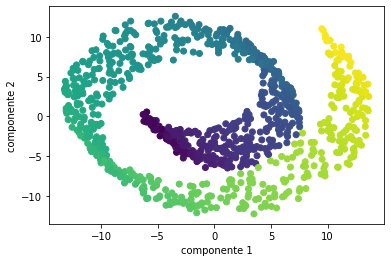

In [24]:
plt.scatter(Y2D[:,0],Y2D[:,1],c=t)
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.show()

Ahora vamos a recuperar los puntos 3D proyectados en el plano (subespacio PCA 2D).

In [22]:
X3D_inv = pca.inverse_transform(Y2D)

Por supuesto, **hubo cierta pérdida de información durante el paso de proyección**, por lo que los puntos 3D recuperados *no son exactamente iguales a los puntos 3D originales*:

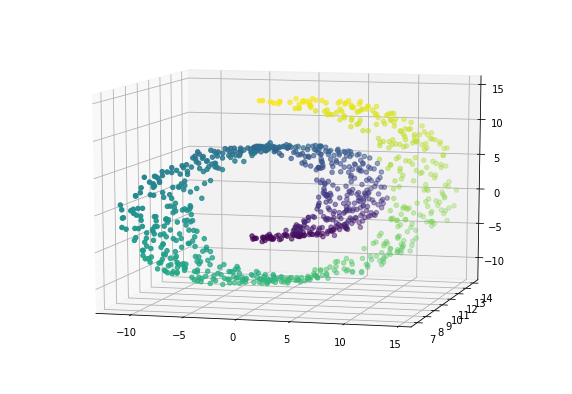

In [23]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(X3D_inv[:,0], X3D_inv[:,1], X3D_inv[:,2],c=t)
ax.view_init(elev=10, azim=-75)
plt.show()

Podemos calcular el error de reconstrucción:

In [6]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

37.33439046245999

\Las reconstrucciones de ambos métodos **no son idénticas** porque la clase PCA de Scikit-Learn se encarga automáticamente de revertir el centrado medio, *pero si restamos la media, obtenemos la misma reconstrucción*.

El objeto PCA da acceso a los componentes principales que calculó:

In [25]:
pca.components_

array([[ 0.56791312,  0.15670748,  0.80803308],
       [-0.77712377, -0.2213858 ,  0.5891239 ]])

# Ejercicio 1

- Presente el problema de optimización de PCA como un algoritmo generativo (reconstrucción o filtrado de datos), y compare el problema de optimización desde el punto de vista generativo vs. preservación de la varianza. (Ver [material de apoyo PCA](https://github.com/amalvarezme/AnaliticaDatos/blob/master/4_NoSupervisado/otros/DemostracionPCA.pdf)).



### Varianza retenida (explicada)

- El valor propio relacionado con cada compoenente, codifica la varianza retenida del espacio de entrada.

Por ejemplo, veamos las razones de varianza explicadas de los dos primeros componentes del conjunto de datos 3D representados 

In [8]:
pca.explained_variance_ratio_

array([0.40782396, 0.3020019 ])


Esto le indica que **el 40.8% de la varianza del conjunto de datos se encuentra a lo largo del primer eje**, y el **30.2% se encuentra a lo largo del segundo eje**. 

### Determinar el número de dimensiones proyectas

El siguiente código calcula PCA sin reducir la dimensionalidad, luego calcula el número mínimo de dimensiones requeridas para preservar el 95% de la variación del conjunto de entrenamiento (se utilizará la base de datos Mnist que tiene 784 dimensiones de entrada).

In [26]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist        = fetch_openml('mnist_784', version=1)#descargar mnist desde sklearn
mnist.target = mnist.target.astype(np.uint8)#etiquetas objetivo (clases)

X = mnist["data"]
y = mnist["target"]
print(X.shape,y.shape)

(70000, 784) (70000,)


In [27]:
#se submuestrea para facilidad en cálculos
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.98,random_state=123)
print(X_train.shape,y_train.shape)

(1400, 784) (1400,)


In [28]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d      = np.argmax(cumsum >= 0.95) + 1 #varianza acumulada ordenando componentes
d

138

También podemos establecer *n_components = d* y ejecutar PCA nuevamente. Sin embargo, hay una opción mucho mejor: en lugar de especificar el número de componentes principales que desea conservar, puede establecer *n_components* para que sea flotante entre 0.0 y 1.0, lo que indica la relación de varianza que desea conservar:

In [29]:
pca       = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

138

In [30]:
np.sum(pca.explained_variance_ratio_)

0.9505055557059698

- Otra opción más es **trazar la varianza explicada en función del número de dimensiones** (simplemente trazar *cumsum*; ver Figura a continuación). 

- Por lo general, habrá un codo en la curva, donde la variación explicada deja de crecer rápidamente. Puede pensar en esto como la dimensionalidad intrínseca del conjunto de datos. 

- En este caso, puede ver que reducir la dimensionalidad a unas 100 dimensiones no perdería demasiada varianza explicada.

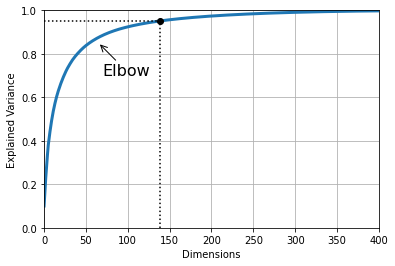

In [31]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

### PCA para compresión de datos

 **Ejemplo:** intentemos aplicar PCA al conjunto de datos MNIST mientras conserva el $95\%$ de su varianza. 
 
Debería encontrar que cada instancia tendrá un poco más de $150$ características, en lugar de las características $784$ originales. 

In [45]:
pca       = PCA(n_components=0.95)
X_train = np.array(X_train)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

138

- Entonces, aunque se conserva la mayor parte de la variación, ¡el conjunto de datos ahora es inferior al $20\%$ de su tamaño original!. 

- Esta es una relación de compresión razonable, y podemos ver cómo esto puede acelerar enormemente un algoritmo de clasificación (como un clasificador SVM).

**Ejemplo:** En el siguiente código se comprime el conjunto de datos MNIST a $154$ dimensiones, luego usa el método *inverse_transform()* para descomprimirlo nuevamente a $784$ dimensiones. La  siguiente Figura muestra algunos dígitos del conjunto de entrenamiento original (a la izquierda) y los dígitos correspondientes después de la compresión y descompresión. Puede ver que hay una ligera pérdida de calidad de imagen, pero los dígitos aún están casi intactos.

(35, 784)
(35, 784)


Text(0.5, 1.0, 'Compressed')

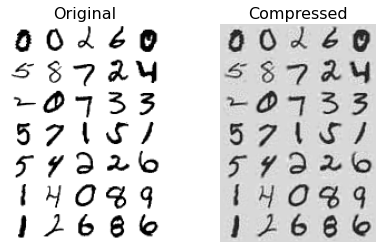

In [46]:
import matplotlib as mpl

pca         = PCA(n_components = 154)
X_reduced   = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

def plot_digits(instances, images_per_row=5, **options):
    size           = 28
    images_per_row = min(len(instances), images_per_row)
    print(instances.shape)
    images         = [instance.reshape(size,size) for instance in instances]
    n_rows         = (len(instances) - 1) // images_per_row + 1
    row_images     = []
    n_empty        = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::40])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::40])
plt.title("Compressed", fontsize=16)
#save_fig("mnist_compression_plot")

### Randomized PCA

- Como alternativa para acelarar el computo de las componentes.

In [ ]:
rnd_pca       = PCA(n_components=154, svd_solver="randomized")
X_reduced     = rnd_pca.fit_transform(X_train)
X_reduced_pca = X_reduced

De manera predeterminada, *svd_solver* en realidad está configurado como *"auto": Scikit-Learn usa automáticamente el algoritmo PCA aleatorizado si $m$ o $n$ es mayor que 500 y %d% es menor al $80\%$ de $m$ o $n$, o si no usa el enfoque SVD completo. Si desea forzar a Scikit-Learn a usar SVD completo, puede configurar el hiperparámetro *svd_solver* en *"full"*.

### Incremental PCA

**Ejemplo:** El siguiente código divide el conjunto de datos MNIST en $100$ mini lotes (usando la función *array_split()* de NumPy) y los alimenta a la clase *IncrementalPCA* de Scikit-Learn para reducir la dimensionalidad del conjunto de datos MNIST a $154$ dimensiones (como antes). Tenga en cuenta que debe llamar al método *partial_fit()* con cada mini lote en lugar del método *fit()* con todo el conjunto de entrenamiento:

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 5
inc_pca   = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") 
    inc_pca.partial_fit(X_batch)

X_reduced           = inc_pca.transform(X_train)
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::40])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::40])
plt.tight_layout()

In [ ]:
X_reduced_inc_pca = X_reduced

Comparemos los resultados de transformar MNIST usando PCA regular y PCA incremental. Primero, los promedios son iguales:

In [ ]:
np.allclose(pca.mean_, inc_pca.mean_)

Pero los resultados no son exactamente idénticos. El PCA incremental brinda una muy buena solución aproximada, pero no es perfecta.

- También, podemos usar la clase *memmap* de NumPy, que le permite manipular una gran matriz almacenada en un archivo binario en el disco duro como si estuviera completamente en la memoria.

- La clase carga solo los datos que necesita en la memoria, cuando los necesita (mini lotes - mini batch). Como la clase *IncrementalPCA* usa solo una pequeña parte de la matriz en un momento dado, el uso de la memoria permanece bajo control. 

-Esto hace posible llamar al método habitual *fit()*, como puede ver en el siguiente código:

Creemos la estructura *memmap()* y copiemos los datos MNIST en ella. Esto normalmente lo haría un primer programa:

In [ ]:
from tempfile import mkdtemp
import os.path as path
filename = path.join(mkdtemp(), 'my_mnist.data')
m, n     = X_train.shape

X_mm    = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

Ahora, eliminar el objeto *memmap()* activará su finalizador de Python, lo que garantiza que los datos se guarden en el disco.

In [ ]:
del X_mm

Luego, otro programa cargaría los datos y los usaría para el entrenamiento:

In [ ]:
X_mm       = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))
batch_size = m // n_batches
inc_pca    = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

In [ ]:
rnd_pca   = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

### Kernel PCA

- El algoritmo [Kernel PCA](https://en.wikipedia.org/wiki/Kernel_principal_component_analysis) permite calcular los componentes principales a partir de un mapeo no lineal basado en funciones núcleo.

# Ejercicio 2

- Presente un paralelo entre el problema de optimización de PCA y el de Kernel PCA.


**Ejemplo:** el siguiente código utiliza la clase *KernelPCA* de Scikit-Learn para realizar kPCA con un kernel RBF.

- Se utilizará el swiss-roll para facilitar la visualización.

In [ ]:
from sklearn.decomposition import KernelPCA

#se ilustra nuevamente sobre swiss roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)


rbf_pca   = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

In [ ]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9
plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
#save_fig("kernel_pca_plot")
plt.show()

La Figura muestra el rollo suizo, reducido a dos dimensiones usando un núcleo lineal (equivalente a simplemente usar la clase *PCA*), un núcleo RBF y un núcleo sigmoide (Logístico).

### kPCA: Definiendo el kernel y sus hiperparámetros

- Como kPCA es un algoritmo de aprendizaje no supervisado, *no existe una medida de rendimiento obvia para ayudarlo a seleccionar los mejores valores de kernel e hiperparámetros*. 

- Sin embargo, la reducción de dimensionalidad es a menudo un paso de preparación para una tarea de aprendizaje supervisada (por ejemplo, clasificación), por lo que simplemente puede usar la **búsqueda de cuadrícula** para seleccionar el núcleo y los hiperparámetros conducen al mejor rendimiento en esa tarea.

**Ejemplo:** el siguiente código crea una guía de dos pasos para la clasificación de la base de datos Mnist.

- Primero reduciendo la dimensionalidad a dos dimensiones usando kPCA, luego aplicando Regresión logística para la clasificación. 

- Se utiliza *GridSearchCV* para encontrar el mejor valor de kernel y gamma para kPCA para obtener la mejor precisión de clasificación al final de la guía:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train, y_train)

Los mejores kernels e hiperparámetros están disponibles a través de la variable *best_params_*:

In [ ]:
print(grid_search.best_params_)

**Tal vez se pregunte cómo realizar la reconstrucción de una instancia proyectada con kPCA?**. 

- Una solución es entrenar un modelo de regresión supervisado, con las instancias proyectadas como el conjunto de entrenamiento y las instancias originales como los objetivos. 

- Scikit-Learn lo hará automáticamente si configura *fit_inverse_transform = True*, ([pre-image problem](https://www.aaai.org/Papers/ICML/2003/ICML03-055.pdf)) como se muestra en el siguiente código:

In [ ]:
from sklearn.metrics import mean_squared_error

rbf_pca    = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced  = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)
mean_squared_error(X, X_preimage)

Podemos usar GridSearchCV para encontrar el núcleo y los hiperparámetros que minimizan este error de reconstrucción pre-imagen.

## Locally Linear Embedding (LLE)

- Se presentan algunas variantes por manifold learning para reducción de dimensionalidad.

- Este tipo de algoritmos pretenden definir localidades lineales, para luego aproximar la variedad (manifold) de la estructura completa de datos.

Ver [Locally Linear Embedding](https://cs.nyu.edu/~roweis/lle/papers/lleintro.pdf).

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle       = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

In [ ]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

#save_fig("lle_unrolling_plot")
plt.show()

RESULTADO:
- Como podemos ver, el rollo suizo está completamente desenrollado y **las distancias entre las instancias están localmente bien conservadas**. 
- Sin embargo, **las distancias no se conservan a mayor escala**: la parte derecha del rollo suizo desenrollado se estira, mientras que la parte izquierda se aprieta. Sin embargo, LLE hizo un buen trabajo modelando el múltiple.

## Escalado multi-dimensional - Multidimensional scaling (MDS).

- El [MDS](https://en.wikipedia.org/wiki/Multidimensional_scaling) se puede entender como extensión del principio de reconstrucción de PCA; pero permite definir distintas métricas de asociación entre puntos.

In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

# Isometric feature mapping (Isomap)

- [Isomap](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.211.5680&rep=rep1&type=pdf) es una extensión de LLE desde teoría de grafos.

In [ ]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

# t-distributed stochastic neighborhood embedding

- [t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf?fbclid=IwA) es de los algoritmos más potentes en reducción de dimensión dado que permite unir los principios de manifold learning y probabilidades, para lidear con el problema de concentración de las normas (métricas en espacios de alta dimensión se distribuyen muy diferente a métricas en espacios de baja dimensión).

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [ ]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

#save_fig("other_dim_reduction_plot")
plt.show()

# Ejercicio 3

1.  Consulte en que consiste el algoritmo [eigenfaces](https://direct.mit.edu/jocn/article/3/1/71/3025/Eigenfaces-for-Recognition). Compare el modelo de eigenfaces para reducción de dimensión con el algoritmo PCA. Aplique eigenfaces a Mnist sobre el conjunto `X_train` y grafique las dos primeras dimensiones con las imagenes originales sobre cada punto proyectado, y presente las cinco primeras "eigenfaces" en dibujo tipo imagen.

2. Utilizando la base de datos muestreada Mnist en `X_train` y `y_train`, realice una análisis comparativo en términos del coeficiente de silueta del agrupamiento de los datos a 2 dimensiones utilizando kmeans. Considere los métodos: PCA, kernel PCA rbf, LLE, y t-SNE.

3. Repita el punto 1. sin utilizar reducción de dimensión (aplique Kmeans directamente sobre `X_train`) y discuta. 

In [ ]:
#Ayuda de código
red = PCA(n_components=0.9)
Z = red.fit_transform(X_train)


In [ ]:
#graficar 2D con imágenes originales
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
#img_w y img_h representan la resolución original de los datos
def plot_mnist_2d(Z,images,img_w=28,img_h=28,zoom=0.5,cmap='jet'):
    fig, ax = plt.subplots(figsize=(10,6))
    for i in range(Z.shape[0]):
        #print('img',i+1,'/',Z.shape[0])
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom,cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i,0], Z[i,1])])
        ax.autoscale()

In [ ]:
plot_mnist_2d(Z,X_train,img_w=28,img_h=28,zoom=0.5,cmap='binary')
plt.xlabel('componente 1')
plt.xlabel('componente 2')
plt.title('Proyección con imágenes originales')
plt.show()

plt.figure(figsize=(11,6))
plt.scatter(Z[:,0],Z[:,1],c=y_train)
plt.xlabel('componente 1')
plt.xlabel('componente 2')
plt.title('Proyección con etiquetas originales')
plt.colorbar()
plt.show()

In [ ]:
#graficar componentes como "eigenfaces"
print(red.components_.shape)


In [ ]:
n_rows = 1
n_cols = 5
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
#resolución imagenes
img_w = 28
img_h = 28

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(abs(red.components_[index].reshape(img_w,img_h)), 
                    vmin=abs(red.components_).min(), vmax=abs(red.components_).max(),cmap="jet", interpolation="nearest")
        plt.axis('off')
        plt.title("eigenface" + str(index), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()